In [37]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings
import numpy as np

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [30]:
import pandas as pd

# Load the data
df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/final_pso_pipeline_results_week_1.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6478 entries, 0 to 6477
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                6478 non-null   float64
 1   frechet_distance     6478 non-null   float64
 2   play_id              6478 non-null   int64  
 3   game_id              6478 non-null   int64  
 4   week_num             6478 non-null   int64  
 5   displayName          6478 non-null   object 
 6   position             6478 non-null   object 
 7   gameId               6478 non-null   int64  
 8   playId               6478 non-null   int64  
 9   passResult           3411 non-null   object 
 10  expectedPointsAdded  6478 non-null   float64
 11  defensiveTeam        6478 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 607.4+ KB


In [32]:
# Replace NaN in 'passResult' with 'R' (for run plays)
df['passResult'].fillna('R', inplace=True)

# Step 2: Check for Duplicates
# Ensure no duplicates based on game, play, and nflId
if df.duplicated(subset=['game_id', 'play_id', 'nflId']).any():
    print("There are duplicates based on game, play, and nflId.")
    # Optional: Remove duplicates
    df = df.drop_duplicates(subset=['game', 'play', 'nflId'])

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6478 entries, 0 to 6477
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                6478 non-null   float64
 1   frechet_distance     6478 non-null   float64
 2   play_id              6478 non-null   int64  
 3   game_id              6478 non-null   int64  
 4   week_num             6478 non-null   int64  
 5   displayName          6478 non-null   object 
 6   position             6478 non-null   object 
 7   gameId               6478 non-null   int64  
 8   playId               6478 non-null   int64  
 9   passResult           6478 non-null   object 
 10  expectedPointsAdded  6478 non-null   float64
 11  defensiveTeam        6478 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 607.4+ KB


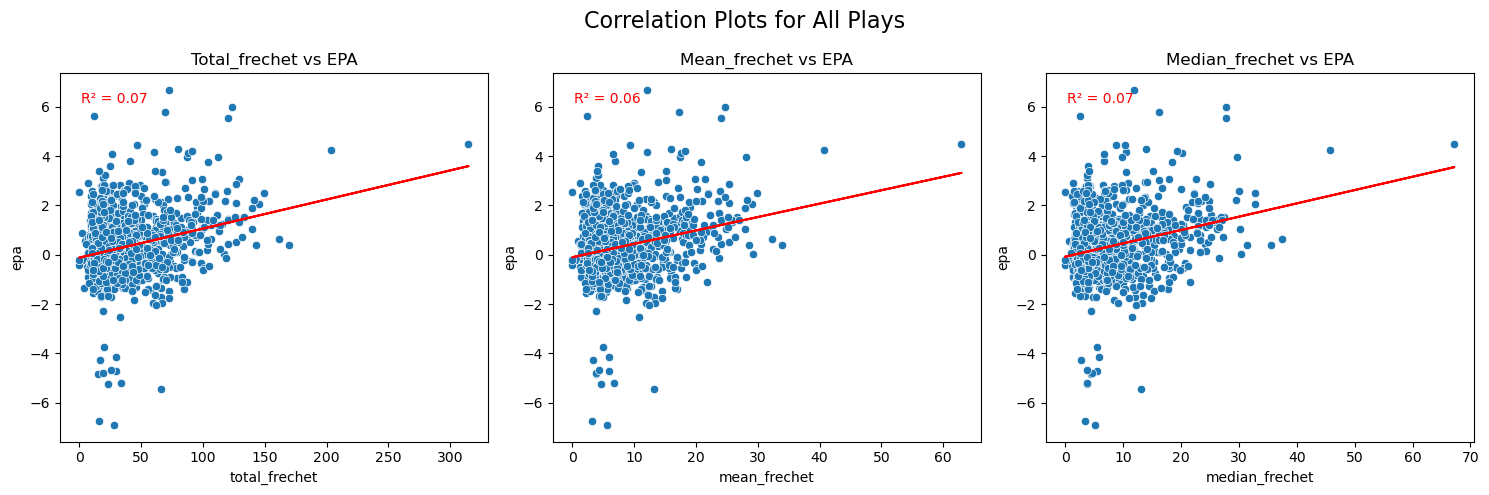

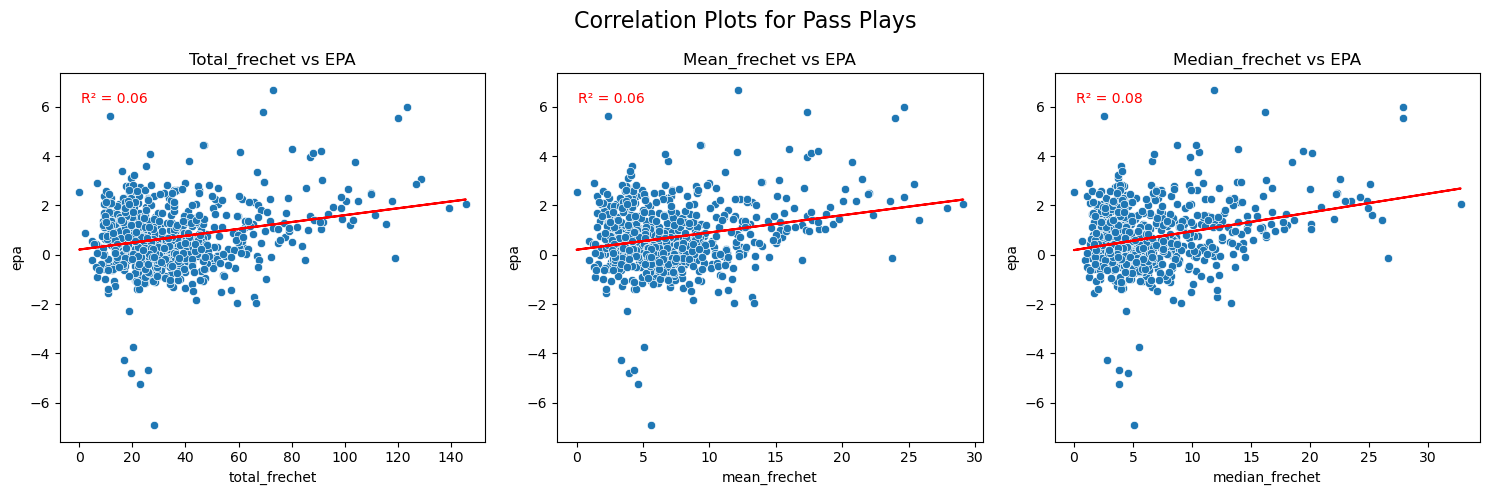

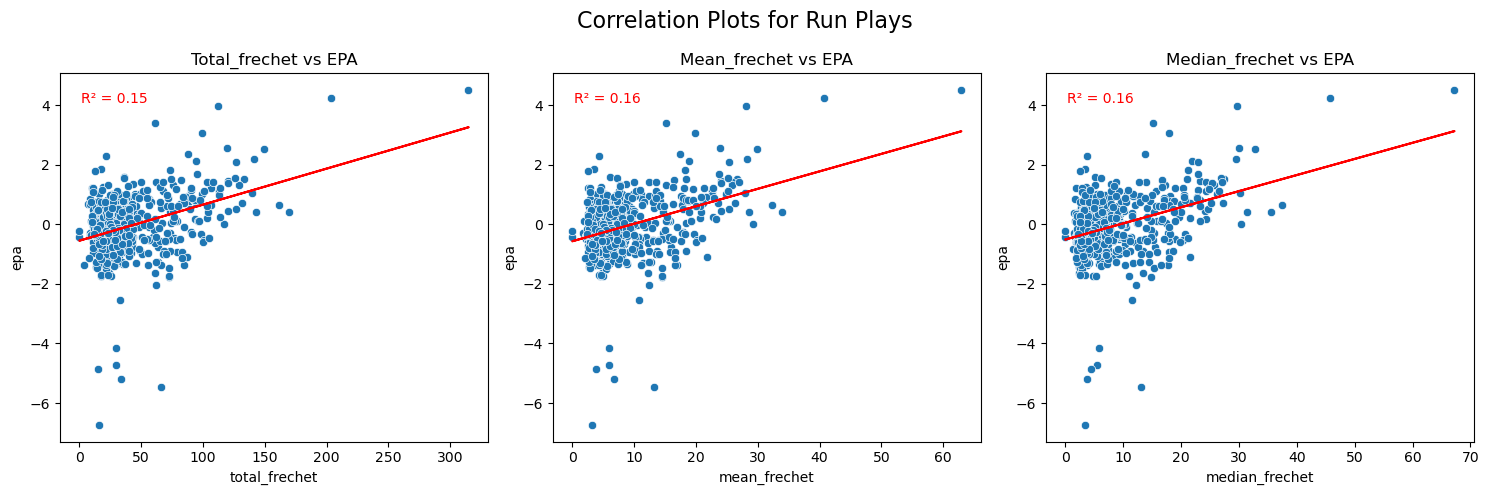

In [35]:
# Aggregate the Fréchet distance
play_level_data = df.groupby(['game_id', 'play_id']).agg(
    total_frechet=('frechet_distance', 'sum'),
    mean_frechet=('frechet_distance', 'mean'),
    median_frechet=('frechet_distance', 'median'),
    epa=('expectedPointsAdded', 'first'),
    passResult=('passResult', 'first')  # Include passResult for filtering
)

# Filter data for pass and run plays
pass_plays = play_level_data[play_level_data['passResult'] == 'C']
run_plays = play_level_data[play_level_data['passResult'] == 'R']

# Define a function to create a correlation plot with trend line
def create_corr_plot(data, play_type):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Correlation Plots for {play_type} Plays', fontsize=16)

    for i, col in enumerate(['total_frechet', 'mean_frechet', 'median_frechet']):
        sns.scatterplot(x=col, y='epa', data=data, ax=axs[i])
        axs[i].set_title(f'{col.capitalize()} vs EPA')

        # Linear regression and plotting the trend line
        slope, intercept, r_value, p_value, std_err = linregress(data[col], data['epa'])
        axs[i].plot(data[col], intercept + slope*data[col], color='red')
        axs[i].text(0.05, 0.95, f'R\u00b2 = {r_value**2:.2f}', transform=axs[i].transAxes, 
                    color='red', verticalalignment='top')
    
    fig.savefig(f'{play_type}_plays_correlation.png')
    plt.tight_layout()
    plt.show()

# Create plots for all plays, pass plays, and run plays
create_corr_plot(play_level_data, 'All')
create_corr_plot(pass_plays, 'Pass')
create_corr_plot(run_plays, 'Run')

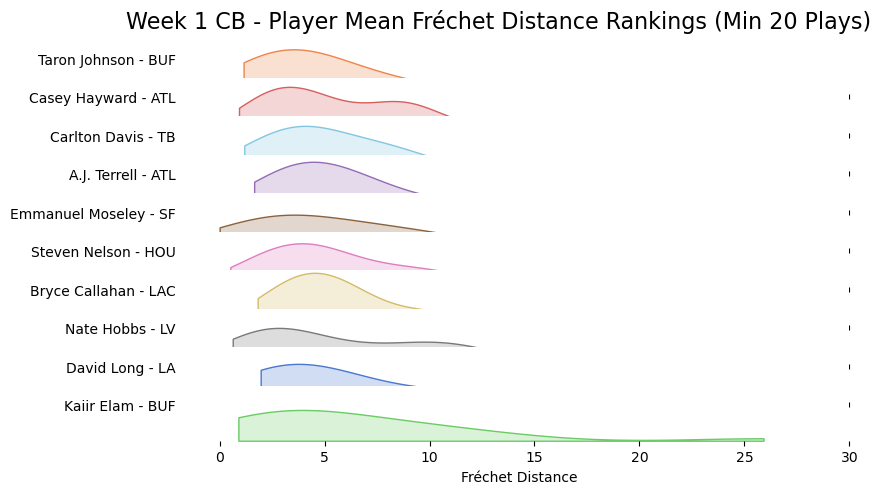

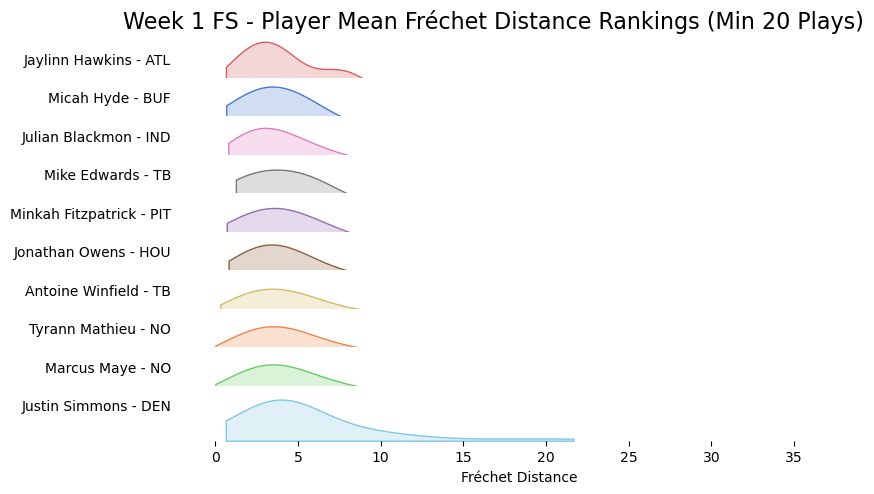

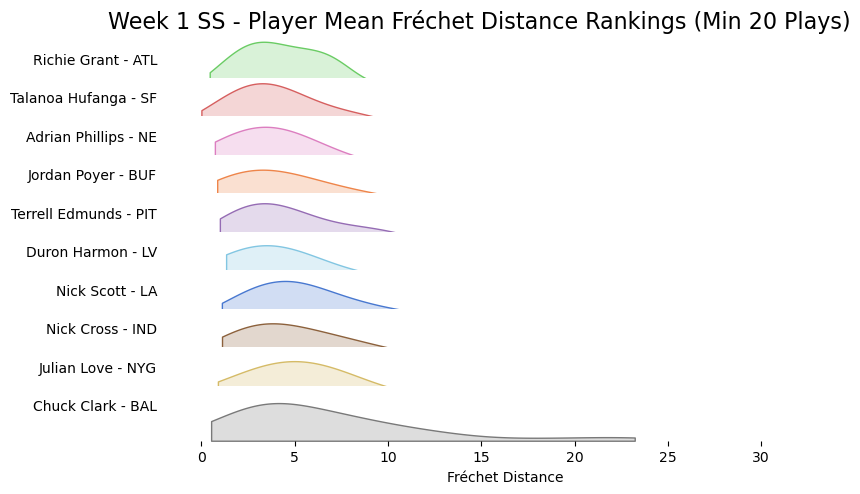

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains 'frechet_distance', 'displayName', 'defensiveTeam', and 'position' columns.

# Calculate mean Fréchet distance, play count, and get the team at the player level
player_stats = df.groupby(['displayName', 'defensiveTeam', 'position'])['frechet_distance'].agg(['mean', 'count']).reset_index()

# Filter out players with fewer than 10 plays
player_stats_filtered = player_stats[player_stats['count'] >= 20]

# Get unique positions
positions = df['position'].unique()

# Loop through each position to create a separate ridge plot
for position in positions:
    # Filter the DataFrame for the current position
    df_position = df[df['position'] == position]

    # Find top players for the current position based on mean Fréchet distance
    top_players = player_stats_filtered[player_stats_filtered['position'] == position].sort_values(by='mean', ascending=True).head(10)
    
    # Create a label combining player's name and team
    top_players['label'] = top_players[['displayName', 'defensiveTeam']].agg(' - '.join, axis=1)

    # Merge the top players' labels back onto the position DataFrame
    df_position = df_position.merge(top_players[['displayName', 'label']], on='displayName', how='left')
    
    # Initialize the FacetGrid object
    g = sns.FacetGrid(df_position, row='label', hue='label', aspect=15, height=.5, palette="muted", row_order=top_players['label'].tolist())
    
    # Map the kdeplot onto the grid
    g.map(sns.kdeplot, 'frechet_distance', clip_on=True, fill=True, common_norm=False, bw_adjust=1, cut=0)

    # Remove 'Density' label and set player names as y-axis labels
    for ax, label in zip(g.axes.flatten(), top_players['label']):
        ax.set_ylabel(label, rotation=0, fontsize=10, labelpad=10)
        ax.yaxis.label.set_horizontalalignment('right')
    
    # Overlap the rows of the grid
    g.fig.subplots_adjust(hspace=-0.3)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.set_xlabels('Fréchet Distance')
    g.despine(bottom=True, left=True)
    # Add a title to the figure
    plt.subplots_adjust(top=0.92)
    g.fig.suptitle(f'Week 1 {position} - Player Mean Fréchet Distance Rankings (Min 20 Plays)', fontsize=16)
    
    # Save the figure for each position
    plt.savefig(f'player_fechet_ridgeplot_week1_{position}.png')
    
    # Show the plot
    plt.show()


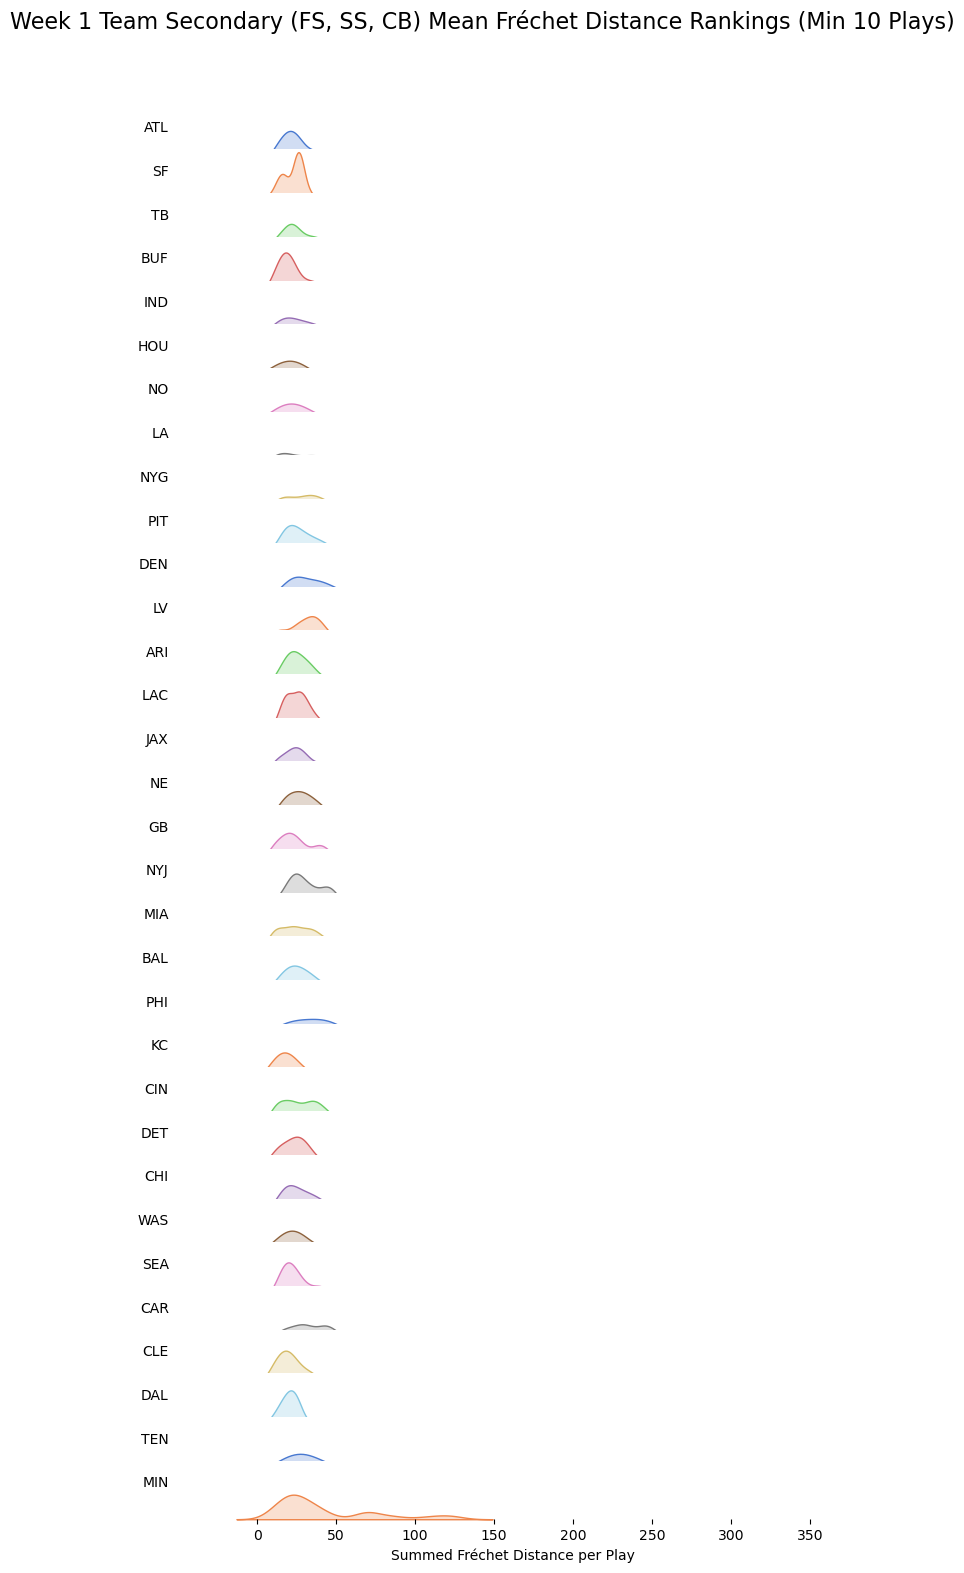

In [90]:
# Calculate sum of Fréchet distance per play at the team level
team_play_distance = df.groupby(['defensiveTeam', 'playId'])['frechet_distance'].sum().reset_index()

# Calculate mean Fréchet distance per play for each team
team_stats = team_play_distance.groupby('defensiveTeam')['frechet_distance'].agg(['mean', 'count']).reset_index()

# Filter out teams with fewer than a certain threshold of plays
min_plays_threshold = 10  # Define a threshold for minimum number of plays
team_stats_filtered = team_stats[team_stats['count'] >= min_plays_threshold]

# Rank the teams by average Fréchet distance
team_stats_filtered = team_stats_filtered.sort_values(by='mean', ascending=True)

# Select top N teams for visualization
top_teams = team_stats_filtered.head(32)  # Adjust N here as needed

# Merge the top teams' data back onto the original team_play_distance DataFrame
team_play_distance = team_play_distance.merge(top_teams[['defensiveTeam']], on='defensiveTeam', how='inner')

# Initialize the FacetGrid object with teams
g = sns.FacetGrid(team_play_distance, row='defensiveTeam', hue='defensiveTeam', aspect=15, height=.5, palette="muted")

# Map the kdeplot onto the grid
g.map(sns.kdeplot, 'frechet_distance', clip_on=False, fill=True, common_norm=False, bw_adjust=0.5)

# Remove 'Density' label and set team names as y-axis labels
for ax, label in zip(g.axes.flatten(), top_teams['defensiveTeam']):
    ax.set_ylabel(label, rotation=0, fontsize=10, labelpad=10)
    ax.yaxis.label.set_horizontalalignment('right')

# Overlap the rows of the grid
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.set_xlabels('Summed Fréchet Distance per Play')
g.despine(bottom=True, left=True)

# Add a title to the figure
plt.subplots_adjust(top=0.92)
g.fig.suptitle(f'Week 1 Team Secondary (FS, SS, CB) Mean Fréchet Distance Rankings (Min {min_plays_threshold} Plays)', fontsize=16)
plt.savefig(f'team_secondary_rankings.png')

# Show the plot
plt.show()
